In [2]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

In [3]:
#1.b)
T = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
N = 8
C = np.zeros([N,len(T)])
C[0,:] = [-101.3, 2.55, 0, 102.55, 0, 0, 0, 0]
C[1,:] = [0, 102.45, 0, -4.4, 0, 0, 0, -104.4]
C[2,:] = [-101.3, 0, 0, 4.9, 0, 0, 0, 104.9]
C[3,:] = [7/4, 7/4, 7/4, 100 + 7/4, 0, 0, 0, 0]
C[4,:] = [0, 5/2, 0, 5/2, 0, 100 + 5/2, 0, 0]
C[5,:] = [0, 0, 0, 6, 0, 0, 0, 100 + 6]
C[6,:] = [4.5/4, 4.5/4, 4.5/4, 4.5/4, 4.5/4, 100 + 4.5/4, 0, 0]
C[7,:] = [5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 100 + 5.5/4]
pi = np.array([0.79492002, -1.02540877,  2.05066409, 103.02163487, 101.80152680, 104.48120266, 101.10990798, 103.67216735])


In [4]:
#1.c)
T = np.array([5, 11, 17, 23, 29, 35, 41, 47])/24
ZCB = solve(C, pi)
print(ZCB)

[0.99060312 0.9802517  0.97073639 0.96190516 0.95363276 0.94581595
 0.93836974 0.93122426]


[0.04531828 0.04351833 0.04192989 0.04052809 0.03929101 0.03819928
 0.03723584 0.03638561]
[0.         0.04223985 0.03920865 0.03672388 0.0346985  0.03305848
 0.03174103 0.03069284]


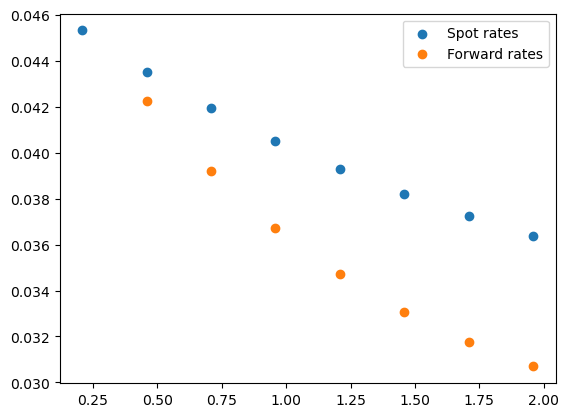

In [5]:
#1.d)
R = fid.spot_rates_from_zcb_prices(T, ZCB)
forward_rates = fid.forward_libor_rates_from_zcb_prices(T, ZCB)
print(R)
print(forward_rates)
plt.scatter(T, R, label='Spot rates')
plt.scatter(T[1:], forward_rates[1:], label='Forward rates')
plt.legend()
plt.show()

In [6]:
#1.e)
R_new = R - 0.001
ZCB_new = fid.zcb_prices_from_spot_rates(T, R_new)
pi_new = C @ ZCB_new
print(pi_new)

[  0.86973647  -1.1740026    2.22576323 103.11782696 101.94643885
 104.68023231 101.25333922 103.86602576]


In [12]:
PV_fixed = 50*0.051*ZCB[1]+50*0.051*ZCB[3]
PV_float = 25*0.052*ZCB[0] + 100*(ZCB[0]-ZCB[3])
print("Swap rate 1", PV_fixed - PV_float)

par_swap_rate = PV_float/(100*165/360*ZCB[1]+50*ZCB[3])
print("swap_rate 3", par_swap_rate)

Swap rate 1 0.7949200199999966
swap_rate 3 0.04469388618153486


In [8]:
#1.g)
accrual_factor = 165/360*ZCB[1]+1/2*ZCB[3]
print(accrual_factor)
PnL = accrual_factor*(0.051-par_swap_rate)
print(PnL)

0.930234610936274
0.005866165334439779


#1.h)
Yes, the PnL is positive, which means that the fixed rate receiver has made a profit. This is because the fixed rate receiver has received a fixed rate that is higher than the par swap rate, which means that the fixed rate receiver has received more money than he has paid out.

In [13]:
#1.i)
C_bond = np.array([0, 2.6, 0, 2.6, 0, 2.6, 0, 102.6])
bond_price = np.sum(C_bond * ZCB)
print(bond_price)

103.0523385081963


In [14]:
#1.j)
replicating_portfolio = C_bond @ inv(C)
print("replicating_portfolio: ", replicating_portfolio)
print("Price: ", replicating_portfolio @ pi)
print("Profit: ", replicating_portfolio @ pi - 100.2)

replicating_portfolio:  [-0.0319491   0.02555447  0.0319491   0.          0.02536585  0.96147572
  0.          0.        ]
Price:  103.05233850819631
Profit:  2.8523385081963113


In [15]:
#1.k)
C_new = np.vstack((C, C_bond))
pi_k = np.append(pi, 100.2)
def f_to_minimize(x):
    h = np.append(x, 1)
    return np.sum((np.dot(h, pi_k))**2)
def ineq(x):
    h = np.append(x, 1)
    return (C_new.T@h)[0] - 0
def eq(x):
    h = np.append(x, 1)
    return (C_new.T@h)[1:] - 0
constraints = [
    {'type': 'ineq', 'fun': ineq},
    {'type': 'eq', 'fun': eq}
]
x0 = np.zeros(8)
res = minimize(f_to_minimize, x0, constraints=constraints).x
replicating_portfolio_k = np.append(res, 1)
print("Replicating portfolio: ", replicating_portfolio_k)
print("Price: ", np.dot(replicating_portfolio_k, pi_k))
print("Cash flows: ", C_new.T @ replicating_portfolio_k)

Replicating portfolio:  [ 3.16642539e-02 -2.55473813e-02 -6.00872086e-02 -3.15519773e-20
 -2.53658537e-02 -9.33622627e-01 -4.47985138e-18  3.33212174e-18
  1.00000000e+00]
Price:  -0.00014912740643069355
Cash flows:  [ 2.87924531e+00  3.27249339e-12 -5.13381375e-19  1.62829306e-10
 -4.58165415e-19  0.00000000e+00  4.58166739e-18 -1.07473568e-08]


In [16]:
#Second approach
#Replicate ZCB[0] without bond. Then scale to price of the profit
#From 1.j
C_target_k = np.array([1, 0, 0, 0, 0, 0, 0, 0])
h = C_target_k @ inv(C)
h *= 2.8523385081963113/0.9906031214634187
replicating_portfolio_k = np.append(h - replicating_portfolio, 1)
print("Replicating portfolio: ", replicating_portfolio_k)
print("Price: ", np.dot(replicating_portfolio_k, pi_k))
print("Cash flows: ", C_new.T @ replicating_portfolio_k)

Replicating portfolio:  [ 0.03166424 -0.02554738 -0.06008868  0.         -0.02536585 -0.93362117
  0.          0.          1.        ]
Price:  0.0
Cash flows:  [2.87939584e+00 0.00000000e+00 0.00000000e+00 8.88178420e-16
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [39]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.02750}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12,
"rate": 0.02980},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03122},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03257},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03384},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03504},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03617},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03724},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03825},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03920}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03782,
"float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04152, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04402, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04577, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04797, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04971, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05105, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05170, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05230, "float_freq":
"semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

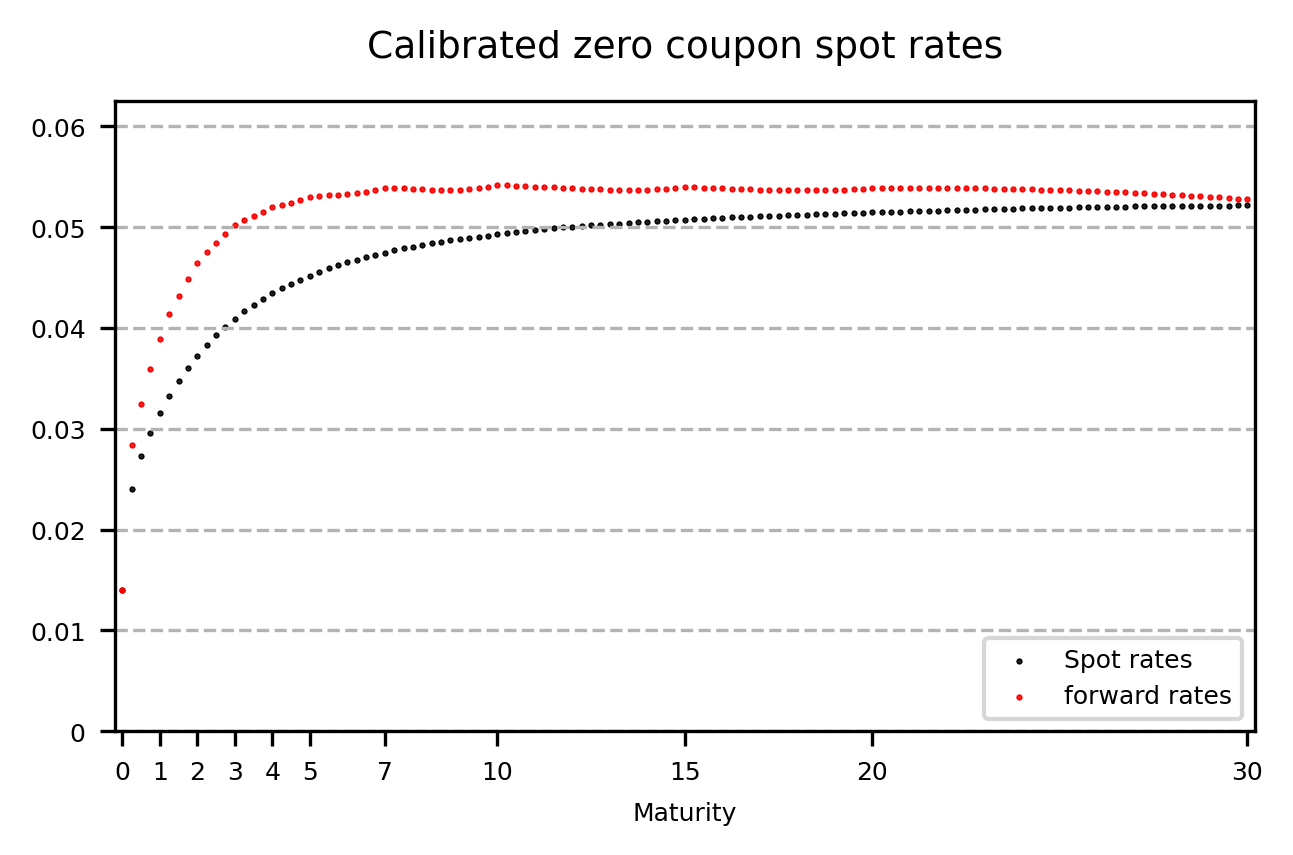

In [43]:
#2.a)

interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_6m = np.array([i*0.5 for i in range(0,61)])
T_3m = np.array([i*0.25 for i in range(0,121)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_3m,T_fit,R_fit,interpolation_options = interpolation_options)

#Plot 
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,
hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="forward rates")
# p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()



In [ ]:
# 2.b)
# Cashflows matrix for the bond
T = np.arange(0.5, 10.5, 0.5)
C = np.zeros(len(T))
# 
C[:19] = 2.5
C[19]= 102.5
pi_2_b = C @ p_inter[1:21]
print(f"Price {pi_2_b}")
# Fid functions
ytm_fr = fid.ytm(pi_2_b, T, C)
mac_dur = fid.macauley_duration(pi_2_b, T,C, ytm_fr)
mod_dur = fid.modified_duration(pi_2_b, T,C,ytm_fr)
convex = fid.convexity(pi_2_b, T,C, ytm_fr)
print(f"Yield-to-maturity: {ytm_fr}")
print(f"Macauley Durattion: {mac_dur}")
print(f"Modified Durattion: {mod_dur}")
print(f"Convexity: {convex}")
      


Price 100.71704212519342
Yield-to-maturity: 0.04968635467120988
Macauley Durattion: 7.997950060808084
Modified Durattion: 7.619371277159507
Convexity: 73.46537254317197


In [ ]:
# 2.c) 
delta_ytm = 0.001 # Change in YTM (10 bps)               

# Percentage price change using duration only
price_change_duration = -mod_dur * delta_ytm

# Percentage price change using duration and convexity
price_change_duration_convexity = -mod_dur * delta_ytm + 0.5 * convex * (delta_ytm ** 2)

# Print 
print(f"Percentage Price Change (Duration): {price_change_duration:.10f}")
print(f"Percentage Price Change (Duration and Convexity): {price_change_duration_convexity:.10f}")
2332    A

Percentage Price Change (Duration): -0.0076193713
Percentage Price Change (Duration and Convexity): -0.0075826386


In [24]:
#2.d) Finding the accrual factor and par swap rate of the 3Y payer swap
T3 = [0.5 * i for i in range(1,7)]
p3 = p_inter[1:7]

T10 = [0.5 * i for i in range(1,10)]
p10 = p_inter[1:21]
Y3_acc = fid.accrual_factor_from_zcb_prices(0,0,3,"semiannual",T10,p10)
print(f"3Year payer swap accrual factor: {Y3_acc}")

3Year payer swap accrual factor: 2.8119187085920623


In [ ]:
# Second approach
par_swap_rate = 0.04152
par_swap_rate_2_d, accrual_factor_2_d = fid.swap_rate_from_zcb_prices(0, 0, 3, 1, T_inter, p_inter, 0.5)
print("Par swap rate: ", par_swap_rate_2_d)
print("Accrual factor: ", accrual_factor_2_d)

Par swap rate:  0.041520418921395665
Accrual factor:  2.781667598212273


In [26]:
#2.e)
par_swap_rate = 0.04971
par_swap_rate_2_e, accrual_factor_2_e = fid.swap_rate_from_zcb_prices(0, 0, 10, 1, T_inter, p_inter, 0.5)
print("Par swap rate: ", par_swap_rate_2_e)
print("Accrual factor: ", accrual_factor_2_e)

Par swap rate:  0.04970967500840736
Accrual factor:  7.828860337866644


In [27]:
#2.f)
spot_rates_2_f = R_inter + 0.001
p_inter_2_f = fid.zcb_prices_from_spot_rates(T_inter, spot_rates_2_f)
forward_libor_rates_2_f = fid.forward_libor_rates_from_zcb_prices(T_inter, p_inter_2_f)
PnL_2_f_bond = C @ p_inter_2_f[1:21] - pi_2_b
swap_rate_2_f_3Y, accrual_factor_2_f_3Y = fid.swap_rate_from_zcb_prices(0, 0, 3, 1, T_inter, p_inter_2_f, 0.5)
swap_rate_2_f_10Y, accrual_factor_2_f_10Y = fid.swap_rate_from_zcb_prices(0, 0, 10, 1, T_inter, p_inter_2_f, 0.5)
PnL_2_f_3Y = -accrual_factor_2_f_3Y*100*(par_swap_rate_2_d - swap_rate_2_f_3Y)
PnL_2_f_10Y = accrual_factor_2_f_10Y*100*(par_swap_rate_2_e - swap_rate_2_f_10Y)
print("PnL bond: ", PnL_2_f_bond)
print("PnL 3Y: ", PnL_2_f_3Y)
print("PnL 10Y: ", PnL_2_f_10Y)

PnL bond:  -0.7984381975015395
PnL 3Y:  0.2876760742613048
PnL 10Y:  -0.804659544849386


In [28]:
#Second approach
forward_libor_rates_2_f_2 = fid.forward_libor_rates_from_zcb_prices(T_inter, p_inter)
PnL_2_f_3Y = 0.5*100*np.dot(forward_libor_rates_2_f[1:7], p_inter_2_f[1:7]) - 1*100*par_swap_rate_2_d*np.sum(p_inter_2_f[2:7:2])
PnL_2_f_10Y = -0.5*100*np.dot(forward_libor_rates_2_f[1:21], p_inter_2_f[1:21]) + 1*100*par_swap_rate_2_e*np.sum(p_inter_2_f[2:21:2])
print("PnL 3Y: ", PnL_2_f_3Y)
print("PnL 10Y: ", PnL_2_f_10Y)
print(T_inter)

PnL 3Y:  0.28767607426130404
PnL 10Y:  -0.8046595448493932
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30. ]


In [29]:
# 2.g)
principal_2_g = -PnL_2_f_bond/PnL_2_f_3Y*100
print("Principal: ", principal_2_g)

Principal:  277.5476547890793


In [30]:
#2.h)
principal_2_h = -PnL_2_f_bond/PnL_2_f_10Y*100
print("Principal: ", principal_2_h)

Principal:  -99.22683482875753


In [31]:
#2.i)
accrual_duration_factor_2_i_3Y = mod_dur/accrual_factor_2_f_3Y
accrual_duration_factor_2_i_10Y = mod_dur/accrual_factor_2_f_10Y
print("Accrual duration factor 3Y: ", accrual_duration_factor_2_i_3Y)
print("Accrual duration factor 10Y: ", accrual_duration_factor_2_i_10Y)

Accrual duration factor 3Y:  2.7445375085502413
Accrual duration factor 10Y:  0.9781899098774565


In [32]:
#2.j)
data_2_j = copy.deepcopy(data)
for item in data_2_j:
    item['rate'] += 0.001
T_fit_2_j, R_fit_2_j = fid.zcb_curve_fit(data_2_j,interpolation_options = interpolation_options)
T_6m_2_j = np.array([i*0.5 for i in range(0,61)])
p_inter_2_j, R_inter_2_j, f_inter_2_j, T_inter_2_j = fid.zcb_curve_interpolate(T_6m_2_j,T_fit_2_j,R_fit_2_j,interpolation_options = interpolation_options)

pi_2_j_bond = C @ p_inter_2_j[1:21]
swap_rate_2_j_3Y, accrual_factor_2_j_3Y = fid.swap_rate_from_zcb_prices(0, 0, 3, 1, T_inter_2_j, p_inter_2_j, 0.5)
swap_rate_2_j_10Y, accrual_factor_2_j_10Y = fid.swap_rate_from_zcb_prices(0, 0, 10, 1, T_inter_2_j, p_inter_2_j, 0.5)
PnL_2_j_bond = C @ p_inter_2_j[1:21] - pi_2_b
PnL_2_j_3Y = -accrual_factor_2_j_3Y*100*(par_swap_rate_2_d - swap_rate_2_j_3Y)
PnL_2_j_10Y = accrual_factor_2_j_10Y*100*(par_swap_rate_2_e - swap_rate_2_j_10Y)
print("PnL bond: ", PnL_2_j_bond)
print("PnL 3Y: ", PnL_2_j_3Y)
print("PnL 10Y: ", PnL_2_j_10Y)

PnL bond:  -0.7733176826399415
PnL 3Y:  0.2775391073939861
PnL 10Y:  -0.7793380640173504


In [33]:
#2.k)
principal_2_k_3Y = -PnL_2_j_bond/PnL_2_j_3Y*100
print("Principal 3Y: ", principal_2_k_3Y)

Principal 3Y:  278.6337716155307


In [34]:
#2.l)
principal_2_k_10Y = -PnL_2_j_bond/PnL_2_j_10Y*100
print("Principal 10Y: ", principal_2_k_10Y)

Principal 10Y:  -99.2275006630146


In [35]:
#2.n)
#There is a larger risk with the 3Y swap since the principal is so high

In [36]:
#2.m)
accrual_duration_factor_2_m_3Y = mod_dur/accrual_factor_2_j_3Y
accrual_duration_factor_2_m_10Y = mod_dur/accrual_factor_2_j_10Y
print("Accrual duration factor 3Y: ", accrual_duration_factor_2_m_3Y)
print("Accrual duration factor 10Y: ", accrual_duration_factor_2_m_10Y)

Accrual duration factor 3Y:  2.7443666586398954
Accrual duration factor 10Y:  0.9780241921015275


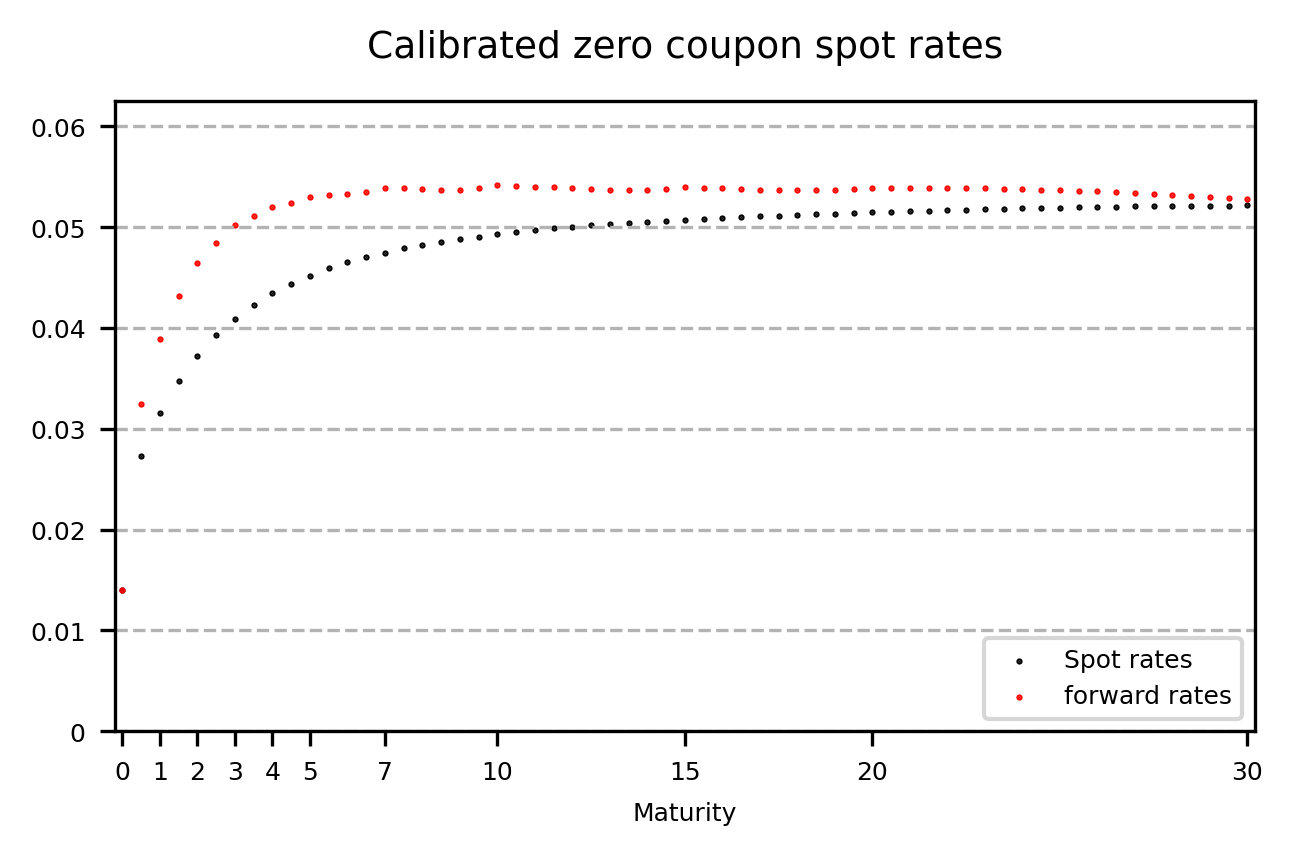